In [8]:
import joblib
import pandas as pd

In [10]:
train = pd.read_csv(r"C:\Users\deepa\DECODEML\vipinsirproject1\train.csv")

In [12]:
pipeline = joblib.load(r"C:\Users\deepa\DECODEML\vipinsirproject1\final_pipeline.pkl")
model = pipeline['model']
preprocessor = pipeline['preprocessor']

In [14]:
model

,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,StratifiedKFo...shuffle=False)
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [16]:
preprocessor

,transformers,"[('num', ...), ('onehot_source', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [18]:
train['total_late'] = (train['Count_3-6_months_late'] +
                       train['Count_6-12_months_late'] +
                       train['Count_more_than_12_months_late'])

In [20]:
x_train=preprocessor.transform(train)

In [22]:
prob_non_renew=model.predict_proba(x_train)[:, 1]

In [24]:
prob_non_renew

array([0.02097572, 0.01138997, 0.02923005, ..., 0.01975867, 0.01417548,
       0.01519215])

In [26]:
prob_renew =1-prob_non_renew

In [28]:
prob_renew

array([0.97902428, 0.98861003, 0.97076995, ..., 0.98024133, 0.98582452,
       0.98480785])

# Numerical Optimization

In [31]:
from scipy.optimize import minimize_scalar
import numpy as np
def net_revenue(I, p, premium):
    E = 10 * (1 - np.exp(-I / 400))
    dp = 0.20 * (1 - np.exp(-E / 5))
    return -((p + dp) * premium - I)
    
p_vals=prob_renew
prem_vals = train['premium'].values

In [33]:
# Select first policy
x_single = preprocessor.transform(train.iloc[[0]])  
p_nonrenewal = model.predict_proba(x_single)[:, 1][0]
p_example = 1 - p_nonrenewal

# Get premium
premium_example = train['premium'].iloc[0]
p_example,premium_example,p_nonrenewal

(0.9790242848917842, 3300, 0.02097571510821581)

In [35]:
train.head(5)

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal,total_late
0,66633,0.086,16805,114110,0.0,0.0,0.0,99.87,8,A,Urban,3300,1,0.0
1,62807,0.010,22638,315120,0.0,0.0,0.0,99.25,19,A,Rural,3300,1,0.0
2,30822,0.312,11685,125100,0.0,0.0,0.0,98.84,13,A,Urban,7500,1,0.0
3,101201,0.276,24829,150200,2.0,0.0,0.0,99.02,17,A,Urban,7500,1,2.0
4,63479,0.308,20445,137880,0.0,0.0,0.0,98.80,11,A,Rural,7500,1,0.0


In [37]:
# Optimize
result = minimize_scalar(
    net_revenue,
    bounds=(0, 2000),
    args=(p_example, premium_example),
    method='bounded'
)
# Output
I_opt = result.x
print(f"Optimal incentive for policy : ${I_opt:.2f}")

Optimal incentive for policy : $183.38


# Batch Optimization for All Policies

In [40]:
I_opts = []
for p_i, P_i in zip(prob_renew, train['premium'].values):
    res = minimize_scalar(
        net_revenue,
        bounds=(0, 2000),
        args=(p_i, P_i),
        method='bounded'
    )
    I_opts.append(res.x)
I_opts = np.array(I_opts)

In [41]:
I_opts

array([183.37969563, 183.37969563, 344.26589742, ..., 446.10129915,
       399.42911363, 555.6055511 ])

# Comparative Analysis

In [43]:
E_vals = 10 * (1 - np.exp(-I_opts / 400))
dp_vals = 0.20 * (1 - np.exp(-E_vals / 5))

baseline_rev = np.sum(prob_renew * train['premium'].values)
opt_rev = np.sum((prob_renew + dp_vals) * train['premium'].values - I_opts)
gain = opt_rev - baseline_rev

print(f"Baseline revenue : ${baseline_rev:,.0f}")
print(f"Optimized revenue : ${opt_rev:,.0f}")
print(f"Net gain : ${gain:,.0f}")

Baseline revenue : $697,857,518
Optimized revenue : $782,146,920
Net gain : $84,289,402


# Aggregate Metrics

In [48]:
# Baseline revenue (no incentive)
rev_no = np.sum(prob_renew * train['premium'].values)

# Fixed 10% incentive
alpha = 0.10
I_fixed = alpha * train['premium'].values
E_fixed = 10 * (1 - np.exp(-I_fixed / 400))
dp_fixed = 0.20 * (1 - np.exp(-E_fixed / 5))
rev_fixed = np.sum((prob_renew + dp_fixed) * train['premium'].values - I_fixed)

# Optimized revenue 
rev_opt = np.sum((prob_renew + dp_vals) * train['premium'].values - I_opts)

In [50]:
print(f"No incentive revenue            : ${rev_no:,.0f}")
print(f"Fixed 10% incentive revenue     : ${rev_fixed:,.0f}")
print(f"Optimized incentive revenue     : ${rev_opt:,.0f}")
print(f"Gain vs no incentive            : ${rev_opt - rev_no:,.0f}")
print(f"Gain vs fixed 10% incentive     : ${rev_opt - rev_fixed:,.0f}")

No incentive revenue            : $697,857,518
Fixed 10% incentive revenue     : $747,531,658
Optimized incentive revenue     : $782,146,920
Gain vs no incentive            : $84,289,402
Gain vs fixed 10% incentive     : $34,615,262


# Per-Policy Statistics

In [53]:
df_eval = pd.DataFrame({
    'premium': train['premium'].values,
    'p_base': prob_renew,
    'I_opt': I_opts,
    'rev_base': prob_renew * train['premium'].values,
    'rev_opt': (prob_renew + dp_vals) * train['premium'].values - I_opts
})

# Revenue Lift
df_eval['lift'] = df_eval['rev_opt'] - df_eval['rev_base']

# Summary stats
print(df_eval.describe())

            premium        p_base         I_opt      rev_base       rev_opt  \
count  67875.000000  67875.000000  67875.000000  67875.000000  67875.000000   
mean   10907.040884      0.936489    372.433169  10281.510392  11523.343206   
std     9398.426180      0.091669    186.005928   9024.799403  10433.164693   
min     1200.000000      0.154118     24.812123    184.941173    187.330120   
25%     5400.000000      0.932802    275.910355   4897.603944   5325.553096   
50%     7500.000000      0.969490    344.265924   7408.105115   8095.575766   
75%    13800.000000      0.985209    486.775624  13401.960120  15012.655372   
max    60000.000000      1.000000    918.288837  59928.000110  69023.390696   

               lift  
count  67875.000000  
mean    1241.832814  
std     1422.412872  
min        2.388948  
25%      405.435872  
50%      682.787661  
75%     1597.857256  
max     9095.390587  


In [55]:
df_eval.head()

,premium,p_base,I_opt,rev_base,rev_opt,lift
0,3300,0.979024,183.379696,3230.780140,3391.076577,160.296437
1,3300,0.988610,183.379696,3262.413099,3422.709536,160.296437
2,7500,0.970770,344.265897,7280.774611,7963.562272,682.787661
3,7500,0.921458,344.265914,6910.933223,7593.720884,682.787661
4,7500,0.957629,344.265906,7182.214541,7865.002203,682.787661


# Visualization

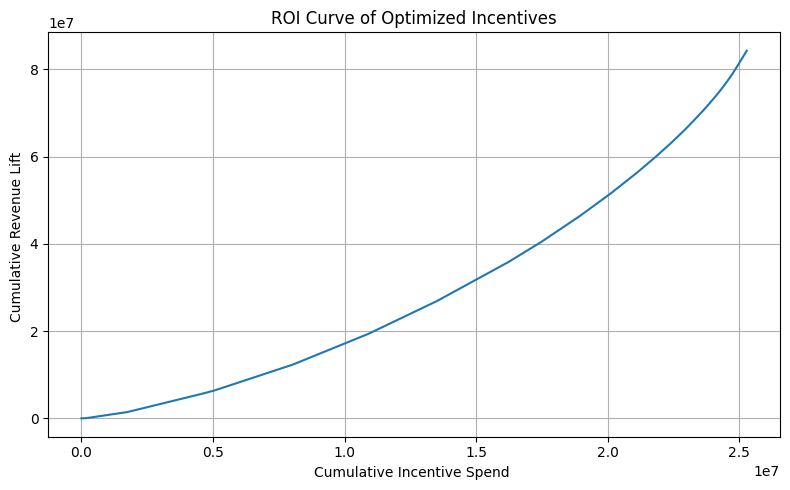

In [58]:
import matplotlib.pyplot as plt
# Sort policies by optimal incentive
df_sorted = df_eval.sort_values('I_opt')

# Incentive Spend vs. Revenue Lift
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(df_sorted['I_opt']), np.cumsum(df_sorted['lift']))
plt.xlabel('Cumulative Incentive Spend ')
plt.ylabel('Cumulative Revenue Lift ')
plt.title('ROI Curve of Optimized Incentives')
plt.grid(True)
plt.tight_layout()
plt.show()